In [4]:
!pip install albumentations --quiet
!pip install -q pykan
from kan import KAN
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 2.1 MB/s eta 0:00:00


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
zip_mappings = {
    "zipped-train-healthy.zip": "train/healthy",
    "zipped-train-sick.zip": "train/sick",
    "test-healthy.zip": "test/healthy",
    "test-sick.zip": "test/sick"
}

In [7]:
import zipfile
import os

for zip_file, target_dir in zip_mappings.items():
    zip_path = f"/content/{zip_file}"
    if zip_file.endswith('.zip') and os.path.exists(zip_path):
      os.makedirs(target_dir, exist_ok=True)
      with zipfile.ZipFile(zip_path, 'r') as zip_ref:
          zip_ref.extractall(target_dir)


print("✅ All datasets unzipped and organized.")

✅ All datasets unzipped and organized.


In [8]:
import os
import shutil
import random
from tqdm import tqdm

def split_train_folder(src_dir, train_dir, val_dir, split_ratio=0.8, seed=42):
    random.seed(seed)

    # Create new folders if not exist
    for folder in [train_dir, val_dir]:
        for cls in os.listdir(src_dir):
            os.makedirs(os.path.join(folder, cls), exist_ok=True)

    # Go through each class
    for cls in tqdm(os.listdir(src_dir), desc="Splitting data"):
        class_path = os.path.join(src_dir, cls)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        random.shuffle(images)

        split_idx = int(len(images) * split_ratio)
        train_imgs = images[:split_idx]
        val_imgs = images[split_idx:]

        # Copy training images
        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, cls, img))

        # Copy validation images
        for img in val_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, cls, img))

# Example usage:
src = "train"              # Your original training folder
train_out = "train_train"  # New training set folder
val_out = "train_val"      # New validation set folder

split_train_folder(src, train_out, val_out)

Splitting data: 100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


In [9]:
import albumentations as A
import cv2
from glob import glob
import os
from tqdm import tqdm

# Adjusted source and output paths
original_train = "train_train"
augmented_train = "train_train_augmented"

os.makedirs(f"{augmented_train}/healthy", exist_ok=True)
os.makedirs(f"{augmented_train}/sick", exist_ok=True)

# Define augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.Resize(224, 224, p=1.0)
])

# Augment images in a given class folder
def augment_class_images(class_name):
    input_paths = glob(f"{original_train}/{class_name}/*.jpg")
    for img_path in tqdm(input_paths, desc=f"Augmenting {class_name}"):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        base_name = os.path.basename(img_path).split('.')[0]
        for i in range(3):  # Generate 3 augmented versions
            aug_img = augment(image=img)['image']
            aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(f"{augmented_train}/{class_name}/{base_name}_aug{i}.jpg", aug_img)

# Apply to both classes
augment_class_images("healthy")
augment_class_images("sick")

print("✅ Data augmentation done. Augmented images saved to /train_train_augmented/")

Augmenting sick: 100%|██████████| 560/560 [00:02<00:00, 212.89it/s]

✅ Data augmentation done. Augmented images saved to /train_train_augmented/


In [10]:
# Define paths
original_train = "train_train"
augmented_train = "train_train_augmented"
merged_train = "train_merged"

# Create merged folder structure
for cls in ["healthy", "sick"]:
    os.makedirs(os.path.join(merged_train, cls), exist_ok=True)

# Helper function to copy all images
def copy_images(src_dir, dest_dir):
    for cls in ["healthy", "sick"]:
        src_class = os.path.join(src_dir, cls)
        dest_class = os.path.join(dest_dir, cls)
        for file in tqdm(os.listdir(src_class), desc=f"Copying {cls} from {src_dir}"):
            src_path = os.path.join(src_class, file)
            dest_path = os.path.join(dest_class, file)
            shutil.copy(src_path, dest_path)

# Merge original + augmented
copy_images(original_train, merged_train)
copy_images(augmented_train, merged_train)

print("✅ Merging complete. Final training data is in /train_merged/")

Copying sick from train_train_augmented: 100%|██████████| 1680/1680 [00:00<00:00, 12187.94it/s]

✅ Merging complete. Final training data is in /train_merged/


In [11]:
import os

# Paths to each class
healthy_dir = "/content/train_merged/healthy"
sick_dir = "/content/train_merged/sick"

# Count files
num_healthy = len(os.listdir(healthy_dir))
num_sick = len(os.listdir(sick_dir))

print(f"🟢 Total healthy images: {num_healthy}")
print(f"🔴 Total sick images: {num_sick}")
print(f"📊 Total training images: {num_healthy + num_sick}")

🟢 Total healthy images: 2240
🔴 Total sick images: 2240
📊 Total training images: 4480


In [12]:
# Compute mean/std of the dataset
transform_basic = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

dataset = ImageFolder(augmented_train, transform=transform_basic)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

def get_mean_std(loader):
    mean = 0.
    std = 0.
    total = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total += batch_samples

    return mean / total, std / total

mean, std = get_mean_std(loader)
print("✅ Dataset Mean:", mean)
print("✅ Dataset Std: ", std)


✅ Dataset Mean: tensor([0.3388, 0.3388, 0.3388])
✅ Dataset Std:  tensor([0.3066, 0.3066, 0.3066])


In [13]:
common_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


In [14]:
train_dataset = ImageFolder("train_merged", transform=common_transform)
val_dataset   = ImageFolder("train_val", transform=common_transform)
test_dataset  = ImageFolder("test", transform=common_transform)


In [15]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


/tmp/ipython-input-1632713272.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_vis = img_vis * torch.tensor(std).view(3,1,1) + torch.tensor(mean).view(3,1,1)


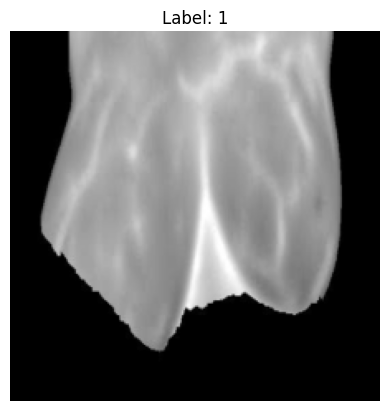

Mean after normalization: tensor([0.0913, 0.0913, 0.0913])
Std after normalization: tensor([1.0813, 1.0813, 1.0813])


In [16]:
# Get sample
img, label = next(iter(train_loader))
img_vis = img[0].clone()

# Un-normalize
img_vis = img_vis * torch.tensor(std).view(3,1,1) + torch.tensor(mean).view(3,1,1)
img_vis = img_vis.permute(1, 2, 0).numpy()

# Plot
plt.imshow(img_vis)
plt.title(f"Label: {label[0].item()}")
plt.axis("off")
plt.show()

# Mean & Std check
print("Mean after normalization:", img[0].mean(dim=(1,2)))
print("Std after normalization:", img[0].std(dim=(1,2)))


ResNet feature shape: torch.Size([16, 2048])


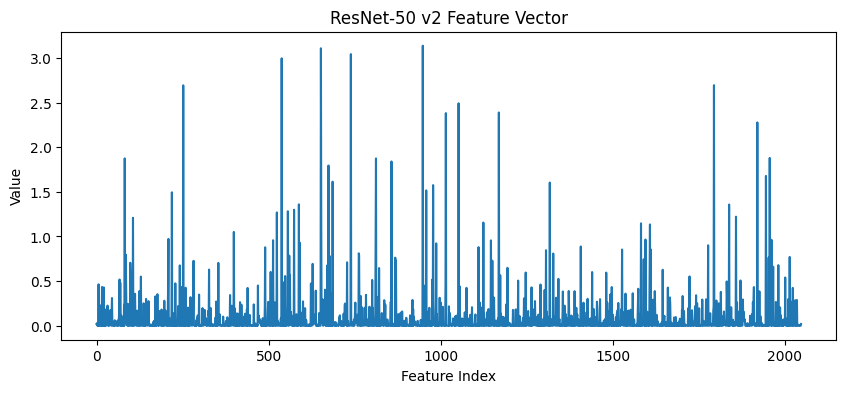

In [17]:
resnet = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')
resnet.fc = torch.nn.Identity()  # remove classification head
resnet.eval().cuda()  # if available

# Example batch
images, labels = next(iter(train_loader))
images = images.cuda()
with torch.no_grad():
    features = resnet(images)

print("ResNet feature shape:", features.shape)  # should be [batch_size, 2048]

# Plot feature vector of 1st image
plt.figure(figsize=(10, 4))
plt.plot(features[0].cpu().numpy())
plt.title("ResNet-50 v2 Feature Vector")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.show()


In [18]:
import torchvision.models as models
import torch.nn as nn
import torch

# Load latest ResNet-50 v2 weights
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
resnet50.fc = nn.Identity()  # Remove final classification layer
resnet50 = resnet50.cuda()
resnet50.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
def extract_features(dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.cuda()
            outputs = resnet50(inputs)
            features.append(outputs.cpu())
            labels.append(targets)
    return torch.cat(features), torch.cat(labels)


In [20]:
# Run extraction for all sets
X_train, y_train = extract_features(train_loader)
X_val, y_val = extract_features(val_loader)
X_test, y_test = extract_features(test_loader)

# Optional: Save them if you want to reuse later
torch.save((X_train, y_train), "train_features.pt")
torch.save((X_val, y_val), "val_features.pt")
torch.save((X_test, y_test), "test_features.pt")

print("✅ All features extracted and saved.")


✅ All features extracted and saved.


In [23]:
from kan import KAN
import torch.nn as nn

# Assume feature vector is 2048 from ResNet-50
input_dim = X_train.shape[1]  # typically 2048
output_dim = len(torch.unique(y_train))  # number of classes, should be 2 (healthy/sick)

model = KAN(width=[input_dim, 64, output_dim], grid=8).to('cuda')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


checkpoint directory created: ./model
saving model version 0.0


In [24]:
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train.cuda())
    loss = loss_fn(outputs, y_train.cuda())
    loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.cuda())
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val.cuda()).float().mean().item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/20], Loss: 0.6935, Val Acc: 0.5036
Epoch [2/20], Loss: 0.6792, Val Acc: 0.7321
Epoch [3/20], Loss: 0.6636, Val Acc: 0.7429
Epoch [4/20], Loss: 0.6506, Val Acc: 0.7286
Epoch [5/20], Loss: 0.6358, Val Acc: 0.7143
Epoch [6/20], Loss: 0.6232, Val Acc: 0.7357
Epoch [7/20], Loss: 0.6106, Val Acc: 0.7607
Epoch [8/20], Loss: 0.5980, Val Acc: 0.7786
Epoch [9/20], Loss: 0.5863, Val Acc: 0.7857
Epoch [10/20], Loss: 0.5738, Val Acc: 0.7893
Epoch [11/20], Loss: 0.5615, Val Acc: 0.7893
Epoch [12/20], Loss: 0.5492, Val Acc: 0.7786
Epoch [13/20], Loss: 0.5370, Val Acc: 0.7821
Epoch [14/20], Loss: 0.5253, Val Acc: 0.7857
Epoch [15/20], Loss: 0.5134, Val Acc: 0.7821
Epoch [16/20], Loss: 0.5019, Val Acc: 0.7786
Epoch [17/20], Loss: 0.4903, Val Acc: 0.7929
Epoch [18/20], Loss: 0.4788, Val Acc: 0.7893
Epoch [19/20], Loss: 0.4672, Val Acc: 0.7893
Epoch [20/20], Loss: 0.4556, Val Acc: 0.8143


In [29]:
# Assuming these are your ResNet+KAN model predictions on validation set
# X_val is your validation input (features)
# y_val is your validation ground truth (labels)

with torch.no_grad():
    predictions = model(X_val.to(device))
    predicted_labels = torch.argmax(predictions, dim=1).cpu()

# Print classification report
print("📋 Classification Report (Validation Set):")
print(classification_report(y_val, predicted_labels, target_names=['Sick', 'Healthy']))


📋 Classification Report (Validation Set):
              precision    recall  f1-score   support

        Sick       0.83      0.79      0.81       140
     Healthy       0.80      0.84      0.82       140

    accuracy                           0.81       280
   macro avg       0.81      0.81      0.81       280
weighted avg       0.81      0.81      0.81       280



In [25]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.cuda())
    test_preds = torch.argmax(test_outputs, dim=1)

from sklearn.metrics import classification_report
print(classification_report(y_test.cpu(), test_preds.cpu(), target_names=["sick", "healthy"]))


              precision    recall  f1-score   support

        sick       0.85      0.42      0.57        40
     healthy       0.62      0.93      0.74        40

    accuracy                           0.68        80
   macro avg       0.73      0.68      0.65        80
weighted avg       0.73      0.68      0.65        80



              precision    recall  f1-score   support

        Sick       0.85      0.42      0.57        40
     Healthy       0.62      0.93      0.74        40

    accuracy                           0.68        80
   macro avg       0.73      0.68      0.65        80
weighted avg       0.73      0.68      0.65        80



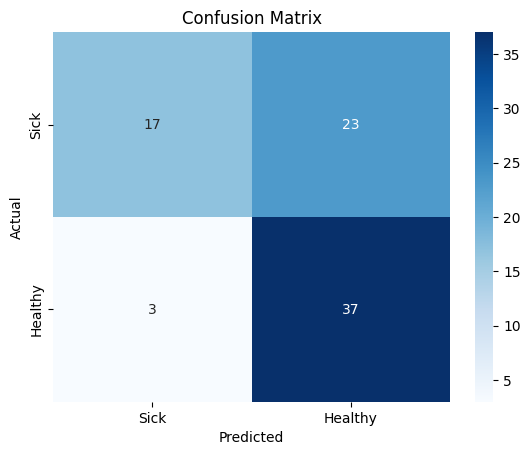

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    predictions = model(X_test.cuda())
    predicted_labels = torch.argmax(predictions, dim=1).cpu()

# 📊 Classification Report
print(classification_report(y_test, predicted_labels, target_names=["Sick", "Healthy"]))

# 📉 Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Sick", "Healthy"], yticklabels=["Sick", "Healthy"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
